# Image Captioning

## Data processing

In [1]:
from pathlib import Path
import torch

import numpy as np
import matplotlib.pyplot as plt

from torchvision.transforms import Resize, ToTensor, RandomRotation, Normalize

import torch.nn as nn
from torch import optim

The file captions.txt is a txt file where each row presents an image_name, the comment_number and the comment, since each image has 5 different captions

In [2]:
import os
import pandas as pd
import zipfile

zip_file_path = "./archive.zip"
extract_folder = "./archive"

# with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
#    zip_ref.extractall(extract_folder)

images_path = os.path.join(extract_folder, "flickr30k_images")
captions_path = "./captions.txt"

archive_df = pd.read_csv(
    captions_path,
    sep=",",
    header=None,
    names=["image_name", "caption_id", "caption"],
    skiprows=1,
)

"""
captions_df['image_path'] = captions_df['image_name'].apply(lambda x: os.path.join(images_path, x))
final_dataset = captions_df[['image_name', 'caption']]
final_dataset.to_csv('expanded_final_dataset.csv', index=False)
print(final_dataset.head)
"""


"\ncaptions_df['image_path'] = captions_df['image_name'].apply(lambda x: os.path.join(images_path, x))\nfinal_dataset = captions_df[['image_name', 'caption']]\nfinal_dataset.to_csv('expanded_final_dataset.csv', index=False)\nprint(final_dataset.head)\n"

## Vocabulary of words

In [3]:
!pip install nltk

In [4]:
from collections import Counter
import nltk
from nltk.tokenize import word_tokenize

nltk.download("punkt")
nltk.download("punkt_tab")


class Vocabulary:
    def __init__(self, freq_threshold=5):
        self.freq_threshold = freq_threshold
        self.word2idx = {}
        self.idx2word = {}
        self.idx = 0

        self.add_word("<PAD>")  # to have all sentences of same target_len
        self.add_word("<SOS>")
        self.add_word("<EOS>")
        self.add_word("<UNK>")  # unknown word

    def add_word(self, word):
        if word not in self.word2idx:
            self.word2idx[word] = self.idx
            self.idx2word[self.idx] = word
            self.idx += 1

    def build_vocabulary(self, sentence_list):
        frequencies = Counter()
        for sentence in sentence_list:
            sentence = self.preprocess(sentence)
            words = word_tokenize(sentence.lower())
            frequencies.update(words)
        for word, freq in frequencies.items():
            if freq >= self.freq_threshold:
                self.add_word(word)

    def numericalize(self, sentence):
        sentence = self.preprocess(sentence)
        tokenized_text = word_tokenize(sentence.lower())
        return [
            self.word2idx.get(word, self.word2idx["<UNK>"]) for word in tokenized_text
        ]

    def one_hot_encode(self, word_or_idx):
        if isinstance(word_or_idx, str):  # If it's a word
            idx = self.word2idx.get(word_or_idx, self.word2idx["<UNK>"])
        elif isinstance(word_or_idx, int):  # If it's already an index
            idx = word_or_idx
        else:
            raise ValueError("Input must be a word (str) or an index (int).")
        one_hot_vector = torch.zeros(len(self.word2idx), dtype=torch.float32)
        one_hot_vector[idx] = 1.0
        return one_hot_vector

    def one_hot_encode_caption(self, caption):
        one_hot_vectors = [self.one_hot_encode(word) for word in caption]
        return torch.tensor(one_hot_vectors)

    def preprocess(self, sentence):
        return "".join([char for char in sentence if char.isalnum() or char.isspace()])

    def __len__(self):
        return len(self.word2idx)


# Probably captions need to be stored like this...


def caption_to_indices(vocab, caption):
    indices = [vocab.word2idx["<SOS>"]]
    for word in caption.split():
        indices.append(vocab.word2idx.get(word.lower(), "<UNK>"))
    indices.append(vocab.word2idx["<EOS>"])
    return indices


def pad_sequence(seq, target_len, pad_idx):
    if len(seq) < target_len:
        seq.extend(
            [pad_idx] * (target_len - len(seq))
        )  # padding at the end of sequence
    return seq[:target_len]


# caption_indices_list = [caption_to_indices(our_vocab, caption) for caption in captions_list]
# pad_idx = our_vocab.word2idx['<PAD>']
# caption_indices_padded = [pad_sequence(indices, target_len, pad_idx) for indices in caption_indices_list]


[nltk_data] Error loading punkt: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>
[nltk_data] Error loading punkt_tab: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>


Example of usage of nltk and Vocabulary class

In [5]:
# how nltk works

sentence = "NLTK is a great toolkit for text processing!"
words = word_tokenize(sentence)
print(words)


# how a vocab works

example_captions = ["A man was riding a bike.", "A child is drawing a black horse."]

example_vocab = Vocabulary(freq_threshold=1)
example_vocab.build_vocabulary(example_captions)

print("Word -> Index:", example_vocab.word2idx)
print("Index -> Word:", example_vocab.idx2word)

caption = "A child is riding a horse"
numericalized_caption = example_vocab.numericalize(caption)
print("Numeric caption:", numericalized_caption)


['NLTK', 'is', 'a', 'great', 'toolkit', 'for', 'text', 'processing', '!']
Word -> Index: {'<PAD>': 0, '<SOS>': 1, '<EOS>': 2, '<UNK>': 3, 'a': 4, 'man': 5, 'was': 6, 'riding': 7, 'bike': 8, 'child': 9, 'is': 10, 'drawing': 11, 'black': 12, 'horse': 13}
Index -> Word: {0: '<PAD>', 1: '<SOS>', 2: '<EOS>', 3: '<UNK>', 4: 'a', 5: 'man', 6: 'was', 7: 'riding', 8: 'bike', 9: 'child', 10: 'is', 11: 'drawing', 12: 'black', 13: 'horse'}
Numeric caption: [4, 9, 10, 7, 4, 13]


Now we will build our own vocabulary using all the captions from the dataset

In [6]:
captions_list = archive_df["caption"].tolist()
our_vocab = Vocabulary(freq_threshold=10)
our_vocab.build_vocabulary(captions_list)
print(our_vocab.word2idx)
print("Length of the vocabulary is: ", len(our_vocab))

{'<PAD>': 0, '<SOS>': 1, '<EOS>': 2, '<UNK>': 3, 'two': 4, 'young': 5, 'guys': 6, 'with': 7, 'shaggy': 8, 'hair': 9, 'look': 10, 'at': 11, 'their': 12, 'hands': 13, 'while': 14, 'hanging': 15, 'out': 16, 'in': 17, 'the': 18, 'yard': 19, 'white': 20, 'males': 21, 'are': 22, 'outside': 23, 'near': 24, 'many': 25, 'bushes': 26, 'men': 27, 'green': 28, 'shirts': 29, 'standing': 30, 'a': 31, 'man': 32, 'blue': 33, 'shirt': 34, 'garden': 35, 'friends': 36, 'enjoy': 37, 'time': 38, 'together': 39, 'several': 40, 'hard': 41, 'hats': 42, 'operating': 43, 'giant': 44, 'pulley': 45, 'system': 46, 'workers': 47, 'down': 48, 'from': 49, 'up': 50, 'above': 51, 'on': 52, 'piece': 53, 'of': 54, 'equipment': 55, 'working': 56, 'machine': 57, 'wearing': 58, 'four': 59, 'top': 60, 'tall': 61, 'structure': 62, 'three': 63, 'large': 64, 'rig': 65, 'child': 66, 'pink': 67, 'dress': 68, 'is': 69, 'climbing': 70, 'set': 71, 'stairs': 72, 'an': 73, 'entry': 74, 'way': 75, 'little': 76, 'girl': 77, 'going': 78,

We now define the maximum length an output caption could be

In [7]:
max_caption_length = max([len(caption.split()) for caption in captions_list])
target_len = max_caption_length + 10
print("The maximum length a caption produced by our model could reach is ", target_len)

"""
#To find which caption has max length
lengths = np.array([len(caption.split()) for caption in captions_list])
max_length_idx = np.argmax(lengths)
max_caption = captions_list[max_length_idx]
print(max_caption)
print("Number of words:", lengths[max_length_idx])
"""

The maximum length a caption produced by our model could reach is  89


'\n#To find which caption has max length\nlengths = np.array([len(caption.split()) for caption in captions_list])\nmax_length_idx = np.argmax(lengths)\nmax_caption = captions_list[max_length_idx]\nprint(max_caption)\nprint("Number of words:", lengths[max_length_idx])\n'

Convert captions to vectors of indexes

In [34]:
def caption_to_padded_indices(vocab, caption, target_len):
    indices = []  # [vocab.word2idx['<SOS>']]
    for word in caption.split():
        indices.append(vocab.word2idx.get(word.lower(), vocab.word2idx["<UNK>"]))
    indices.append(vocab.word2idx["<EOS>"])
    pad_idx = vocab.word2idx["<PAD>"]
    if len(indices) < target_len:
        indices.extend([pad_idx] * (target_len - len(indices)))
    else:
        indices = indices[:target_len]
    return torch.tensor(indices)


caption_indices_padded = [
    caption_to_padded_indices(our_vocab, caption, target_len)
    for caption in captions_list
]

print(captions_list[0])
print(caption_indices_padded[0])
print(caption_indices_padded[0].shape)


Two young guys with shaggy hair look at their hands while hanging out in the yard .
tensor([ 4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,  3,  2,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0])
torch.Size([89])


In [9]:
def caption_to_one_hot_matrix(vocab, caption, target_len):
    """
    Convert a caption (string) to a one-hot encoded matrix.

    Args:
    - vocab (Vocabulary): The vocabulary object.
    - caption (str): The caption string.
    - target_len (int): The target length for padding the sequence.

    Returns:
    - torch.Tensor: A matrix of shape (target_len, vocab_size) where each row is a one-hot encoded vector.
    """
    words = caption.split()
    indices = [vocab.word2idx["<SOS>"]]
    for word in words:
        idx = vocab.word2idx.get(word.lower(), vocab.word2idx["<UNK>"])
        indices.append(idx)
    indices.append(vocab.word2idx["<EOS>"])
    pad_idx = vocab.word2idx["<PAD>"]
    if len(indices) < target_len:
        indices.extend([pad_idx] * (target_len - len(indices)))
    else:
        indices = indices[:target_len]

    one_hot_matrix = torch.zeros((target_len, len(vocab.word2idx)), dtype=torch.float32)
    for i, idx in enumerate(indices):
        one_hot_matrix[i, idx] = 1.0

    return one_hot_matrix


print(captions_list[0])
print(caption_to_one_hot_matrix(our_vocab, captions_list[0], target_len))


Two young guys with shaggy hair look at their hands while hanging out in the yard .
tensor([[0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [1., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.]])


## Division into training, validation and test set

Since the pictures repeat themselves with different captions, we need to make sure that in the train, validation and test sets there are different images regardless, otherwise validation and testing wouldn't be done on new and unseen data.

In [10]:
from torch.utils.data import random_split

image_capidx_df = pd.DataFrame(
    {
        "image_name": archive_df["image_name"],
        "caption": archive_df["caption"],
        "vector_caption": caption_indices_padded,
    }
)
print(image_capidx_df.head)

unique_images = image_capidx_df["image_name"].unique()
num_images = len(unique_images)
unique_images_df = pd.DataFrame(unique_images, columns=["image_name"])

np.random.seed(42)  # for reproducibility
np.random.shuffle(unique_images)

train_images, val_images, test_images = random_split(range(num_images), [0.7, 0.2, 0.1])

train_image_names = unique_images_df.iloc[train_images.indices].image_name.tolist()
val_image_names = unique_images_df.iloc[val_images.indices].image_name.tolist()
test_image_names = unique_images_df.iloc[test_images.indices].image_name.tolist()

train_df = image_capidx_df[
    image_capidx_df["image_name"].isin(train_image_names)
].reset_index(drop=True)

val_df = (
    image_capidx_df[image_capidx_df["image_name"].isin(val_image_names)]
    .groupby("image_name", as_index=False)
    .agg({"caption": lambda x: x.sample(1).values[0]})  # Randomly select one caption
).reset_index(drop=True)

test_df = (
    image_capidx_df[image_capidx_df["image_name"].isin(test_image_names)]
    .groupby("image_name", as_index=False)
    .agg({"caption": lambda x: x.sample(1).values[0]})  # Randomly select one caption
).reset_index(drop=True)

print(f"Train dataset size:\t {train_df.shape[0]}")
print(f"Validation dataset size: {val_df.shape[0]}")  # only contains unique images
print(f"Test dataset size:\t {test_df.shape[0]}")  # only contains unique images

<bound method NDFrame.head of             image_name                                            caption  \
0       1000092795.jpg  Two young guys with shaggy hair look at their ...   
1       1000092795.jpg  Two young  White males are outside near many b...   
2       1000092795.jpg   Two men in green shirts are standing in a yard .   
3       1000092795.jpg       A man in a blue shirt standing in a garden .   
4       1000092795.jpg            Two friends enjoy time spent together .   
...                ...                                                ...   
158910   998845445.jpg  A man in shorts and a Hawaiian shirt leans ove...   
158911   998845445.jpg  A young man hanging over the side of a boat  w...   
158912   998845445.jpg  A man is leaning off of the side of a blue and...   
158913   998845445.jpg  A man riding a small boat in a harbor  with fo...   
158914   998845445.jpg  A man on a moored blue and white boat with hil...   

                                           ve

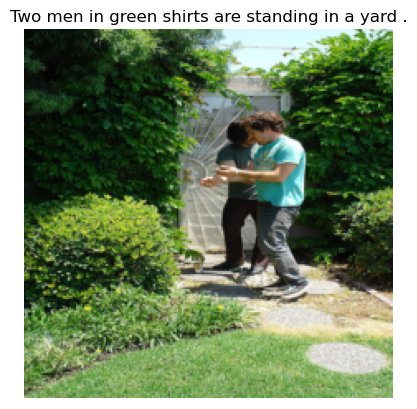

In [11]:
from itertools import chain

from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms


class Flickr30kImages(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        image_name = self.dataframe.iloc[idx]["image_name"]
        caption_index = self.dataframe.iloc[idx]["vector_caption"]

        image_path = os.path.join(images_path, image_name)
        image = Image.open(image_path)

        if self.transform:
            image = self.transform(image)

        return image, caption_index

    def get_caption(self, idx):
        return self.dataframe.iloc[idx]["caption"]


transform = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])

train_dataset = Flickr30kImages(dataframe=train_df, transform=transform)
dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True)


def display_image(index, dataset):
    if index >= len(dataset):
        raise ValueError(f"Index is out of bounds for the dataset")
    image, _ = dataset[index]
    image = image.permute(1, 2, 0).detach().numpy()
    # image = (image * 255).astype('uint8')
    height, width, _ = image.shape
    plt.xlim(0, width)
    plt.ylim(height, 0)
    plt.imshow(image)
    plt.title(dataset.get_caption(index))
    plt.axis("off")
    plt.show()


display_image(2, train_dataset)

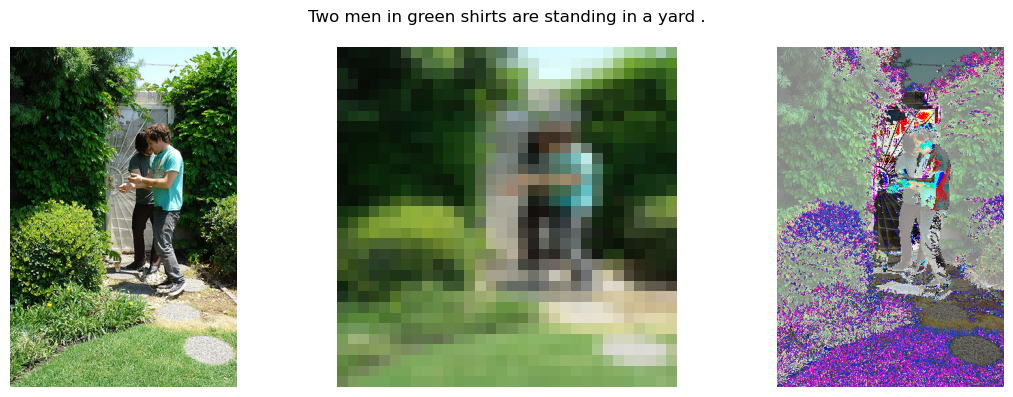

In [12]:
def compare_transforms(transformations, index_image, vocab):
    if not all(isinstance(transf, Dataset) for transf in transformations):
        raise TypeError(
            "All elements in the `transformations` list need to be of type Dataset"
        )

    num_tr = len(transformations)
    fig, axes = plt.subplots(1, num_tr, figsize=(num_tr * 4, 4))

    if num_tr == 1:
        axes = [axes]

    image, _ = transformations[0][index_image]

    for counter, (axis, transf) in enumerate(zip(axes, transformations)):
        image, _ = transf[index_image]
        if isinstance(image, torch.Tensor):
            image = image.permute(1, 2, 0).detach().numpy()
            if image.shape[2] == 3:
                if image.max() <= 1.0:
                    image = (image * 255).astype("uint8")
        axis.imshow(image)
        axis.axis("off")

    plt.suptitle(transformations[0].get_caption(index_image))
    plt.tight_layout()
    plt.show()


example_dataset1 = Flickr30kImages(train_df)
img_size = 32
transform = transforms.Compose([Resize(size=(img_size, img_size)), ToTensor()])
example_dataset2 = Flickr30kImages(train_df, transform)
transform = transforms.Compose([ToTensor(), Normalize(0.5, 1, inplace=True)])
example_dataset3 = Flickr30kImages(train_df, transform)

ex_dataset = [example_dataset1, example_dataset2, example_dataset3]
compare_transforms(ex_dataset, 2, our_vocab)


## NN model

In [5]:
from torchvision import models

import torchvision.transforms.v2 as v2
import torch.nn as nn

vgg_model = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)
feature_dim = vgg_model.classifier[0].in_features
vgg_model.classifier = nn.Identity()


mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
vgg_transform = v2.Compose(
    [
        v2.ToImage(),
        v2.ToDtype(torch.float32, scale=True),
        v2.Resize((224, 224)),
        v2.Normalize(mean, std, inplace=True),
    ]
)

print(feature_dim)


25088


c:\Users\jacob\.conda\envs\dml\Lib\site-packages\torchvision\transforms\v2\_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


## Training

In [56]:
def training_loop(
    model, optimizer, loss_fn, train_loader, val_loader, num_epochs, print_every
):
    print("Starting training")
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    train_losses, val_losses = [], []

    for epoch in range(1, num_epochs + 1):
        model, train_loss = train_epoch(
            model, optimizer, loss_fn, train_loader, val_loader, device, print_every
        )
        val_loss = validate(model, loss_fn, val_loader, device)
        print(
            f"Epoch {epoch}/{num_epochs}: "
            f"Train loss: {sum(train_loss)/len(train_loss):.3f}, "
            f"Val. loss: {val_loss:.3f}, "
        )
        train_losses.extend(train_loss)
        val_losses.append(val_loss)
    return model, train_losses, val_losses


def train_epoch(
    model, optimizer, loss_fn, train_loader, val_loader, device, print_every
):
    model.train()
    train_loss_batches = []
    num_batches = len(train_loader)
    for batch_index, (x, y) in enumerate(train_loader, 1):
        try:
            inputs, targets = x, y
        except ValueError:
            raise ValueError("train_loader should return a tuple (inputs, targets).")
        inputs, target = x.to(device), y.to(device)
        optimizer.zero_grad()
        torch.autograd.set_detect_anomaly(True)
        logits = model.forward(inputs)
        logits = logits.reshape(-1, logits.size(-1))
        targets = targets.reshape(-1)
        loss = loss_fn(logits, targets)
        loss.backward()
        optimizer.step()
        train_loss_batches.append(loss.item())

        if print_every is not None and batch_index % print_every == 0:
            val_loss = validate(model, loss_fn, val_loader, device)
            model.train()
            print(
                f"\tBatch {batch_index}/{num_batches}: "
                f"\tTrain loss: {sum(train_loss_batches[-print_every:])/print_every:.3f}, "
                f"\tVal. loss: {val_loss:.3f}, "
            )

    return model, train_loss_batches


def validate(model, loss_fn, val_loader, device):
    val_loss_cum = 0
    model.eval()
    with torch.no_grad():
        for batch_index, (x, y) in enumerate(val_loader, 1):
            inputs, targets = x.to(device), y.to(device)
            logits = model.forward(inputs)
            logits = logits.reshape(-1, logits.size(-1))
            targets = targets.reshape(-1)
            batch_loss = loss_fn(logits, targets)
            val_loss_cum += batch_loss.item()
    return val_loss_cum / len(val_loader)

In [59]:
img_size = 32
input_size = len(our_vocab.word2idx)
hidden_size = 100
output_size = input_size

model = NN_conv_gru(img_size, input_size, hidden_size, output_size, target_len)
learning_rate = 0.001
optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()
num_epochs = 1
batch_size = 2**3
transform = transforms.Compose([Resize(size=(img_size, img_size)), ToTensor()])

train_dataset = Flickr30kImages(dataframe=train_df, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataset = Flickr30kImages(dataframe=val_df, transform=transform)
val_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

training_loop(
    model, optimizer, loss_fn, train_loader, val_loader, num_epochs, print_every=10
)


Starting training


KeyboardInterrupt: 

In [ ]:
def logits_to_captions(logits, vocab):
    _, predicted_indices = logits.max(dim=-1)
    caption = []
    for idx in predicted_indices:
        word = vocab.idx2word[idx.item()]
        if word == "<EOS>":
            break
        if word != "<SOS>":
            caption.append(word)
    caption_string = " ".join(caption)
    return caption_string
